## Module 6: Homework

### Preparing the dataset

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb

In [2]:
df = pd.read_csv("../../02-regression/data/car_fuel_efficiency.csv")

In [3]:
cat_cols = df.dtypes[df.dtypes == "object"].index

for c in cat_cols:
    df[c] = df[c].str.lower().str.replace(" ", "_")

df = df.fillna(0)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values

del df_train["fuel_efficiency_mpg"]
del df_val["fuel_efficiency_mpg"]

In [5]:
dict_train = df_train.to_dict(orient="records")
dict_val = df_val.to_dict(orient="records")

dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

Q1: Feature used for splitting the data

In [6]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [7]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



Q2: RMSE of random forest regressor

In [8]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

0.4595777223092726

Q3: Value of n_estimators

In [9]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    score = root_mean_squared_error(y_val, y_pred)

    scores.append((n, score))

In [10]:
df_scores = pd.DataFrame(scores, columns=["n_estimators", "rmse"])

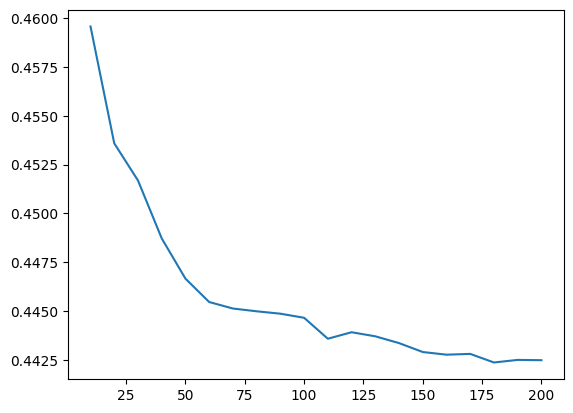

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

Q4: The best max_depth

In [26]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        score = root_mean_squared_error(y_val, y_pred)
    
        scores.append((f"max_depth={d}", n, score))

In [27]:
df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "rmse"])

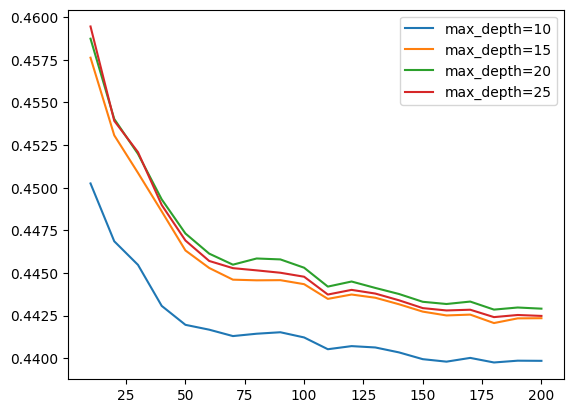

In [28]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == f"max_depth={d}"]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f"max_depth={d}")
plt.legend()

Q5: Most important feature

In [32]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
df_importances = pd.Series(rf.feature_importances_, index=list(dv.get_feature_names_out()))
df_importances.sort_values()

fuel_type=diesel                0.000325
drivetrain=front-wheel_drive    0.000345
drivetrain=all-wheel_drive      0.000357
fuel_type=gasoline              0.000360
origin=asia                     0.000462
origin=europe                   0.000519
origin=usa                      0.000540
num_doors                       0.001635
num_cylinders                   0.002343
model_year                      0.003212
engine_displacement             0.003273
acceleration                    0.011480
horsepower                      0.015998
vehicle_weight                  0.959150
dtype: float64

<BarContainer object of 14 artists>

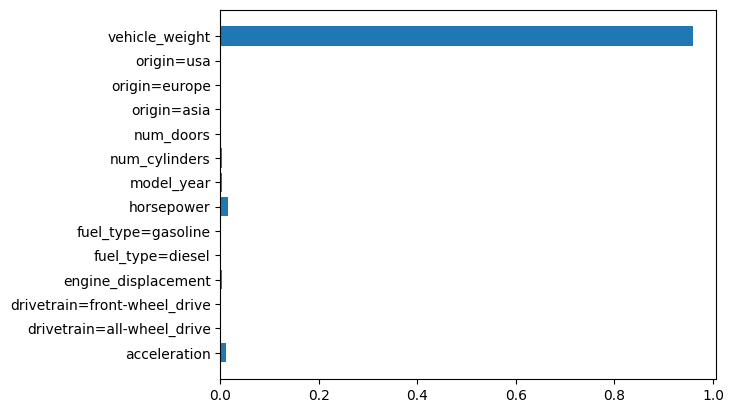

In [38]:
plt.barh(df_importances.index, df_importances)

Q6: Finding eta with best RMSE score

In [45]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=list(dv.get_feature_names_out()))
dval = xgb.DMatrix(X_val, label=y_val, feature_names=list(dv.get_feature_names_out()))

watchlist = [(dtrain, "train"), (dval, "val")]

In [58]:
xgb_params = {
    "eta": 0.3,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 2,
    "seed": 1,
    "verbosity": 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                  verbose_eval=10, evals=watchlist)
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

[0]	train-rmse:1.81393	val-rmse:1.85444
[10]	train-rmse:0.37115	val-rmse:0.43896
[20]	train-rmse:0.33553	val-rmse:0.43376
[30]	train-rmse:0.31475	val-rmse:0.43752
[40]	train-rmse:0.30202	val-rmse:0.43968
[50]	train-rmse:0.28456	val-rmse:0.44140
[60]	train-rmse:0.26768	val-rmse:0.44290
[70]	train-rmse:0.25489	val-rmse:0.44531
[80]	train-rmse:0.24254	val-rmse:0.44689
[90]	train-rmse:0.23193	val-rmse:0.44839
[99]	train-rmse:0.21950	val-rmse:0.45018


0.45017755678087246

In [59]:
xgb_params = {
    "eta": 0.1,
    "max_depth": 6,
    "min_child_weight": 1,
    "objective": "reg:squarederror",
    "nthread": 2,
    "seed": 1,
    "verbosity": 1
}
model = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                  verbose_eval=10, evals=watchlist)
y_pred = model.predict(dval)
root_mean_squared_error(y_val, y_pred)

[0]	train-rmse:2.28944	val-rmse:2.34561
[10]	train-rmse:0.91008	val-rmse:0.94062
[20]	train-rmse:0.48983	val-rmse:0.53064
[30]	train-rmse:0.38342	val-rmse:0.44289
[40]	train-rmse:0.35343	val-rmse:0.42746
[50]	train-rmse:0.33998	val-rmse:0.42498
[60]	train-rmse:0.33054	val-rmse:0.42456
[70]	train-rmse:0.32202	val-rmse:0.42503
[80]	train-rmse:0.31667	val-rmse:0.42563
[90]	train-rmse:0.31059	val-rmse:0.42586
[99]	train-rmse:0.30419	val-rmse:0.42623


0.42622800553359225